In [ ]:
# Intallation packages before use Jupyter

# !pip install pandas
# !pip install -U scikit-learn
# !pip install keras
# !pip install matplotlib
# !pip install kaleido
# !pip install plotly

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
# from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from math import sqrt
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# be able to save images on server
matplotlib.use('Agg')

# Not show warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# !pip install -U kaleido # w Google Colab wymagany Runtime restart po instalacji (Runtime -> Restart Runtime)
import kaleido #required
# kaleido.__version__ #0.2.1

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2024-06-24 23:00:48.760489: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.16.1
Num GPUs Available:  1


In [ ]:
# Zip
# importing the "tarfile" module
import tarfile # type: ignore

# open file
file = tarfile.open('2_150x9.tar.gz')

# extracting a specific file
file.extractall(path='./data/2_150x9/')

file.close()

In [2]:
# Data generator
def data(time, features):
    # Timestep 
    # timestepsPerSample = 20
    timestepsPerSample = time

    # Timesteps in input data
    timestepsPerSampleWholeData = 150

    # Replace 'your_file.csv' with the actual file path
    file_features = './data/2_150x9/2_150x9f.csv'
    file_labels = './data/2_150x9/2_150x9l.csv'

    # Read the .csv file and create an array
    data_strings = np.genfromtxt(file_features, delimiter=';')
    labels_strings = np.genfromtxt(file_labels,delimiter=';')


    # Wycinanie wybranych kolumn
    #  0    1         2             3        4       5        6    7        8
    # RSI, VWAP, HeikenResult, closeHeiken, CMF, Stochastic, OBV, QQE, TrendFilter
    # data_s = data_strings[:,[0,2,3,4,5,6,7,8]]
    if features == 0:
        data_s = data_strings[:,[0,4,5,8]]
    elif features == 1:
        data_s = data_strings[:,[0,1,4,5,6,8]]
    elif features == 2:
        data_s = data_strings[:,:]
        
    num_features = data_s.shape[1]
    # print(data_strings[:3])
    # print(data_s[:3])

    
    # Convert from strings to float and int
    X = data_s.astype(float).reshape((-1,timestepsPerSampleWholeData,num_features))
    Y = labels_strings.astype(float).reshape((-1,6))
    # print(X.shape)
    # print(Y.shape)

    # Modification from imported to new size X[samples,timesteps]
    X_mod = X[1000:11000,timestepsPerSampleWholeData - timestepsPerSample:]
    Y_mod = Y[1000:11000]
    timestepsPerSampleWholeData = X_mod.shape[1]
    # print(X_mod.shape)
    # print(Y_mod.shape)
    # print(X_mod[:1])

    # Splitting
    x_train, x_test, Y_train, Y_test = train_test_split(X_mod,Y_mod, test_size=0.15, shuffle=False)
    y_train = Y_train[:, 0:2]
    y_test = Y_test[:, 0:2]
    # print(y_train[:2])
    # print(y_test[:2])

    # Summarize
    num_samples = x_train.shape[0]
    test_samples = x_test.shape[0]
    print(f"Train shape: {x_train.shape}")
    print(f"Timesteps: {timestepsPerSampleWholeData}")
    print(f"Train Samples: {num_samples}")
    print(f"Test Samples: {test_samples}")
    print(f"Num features: {num_features}")
    return x_train, x_test, y_train, y_test, Y_test

In [3]:
# fit lstm model
from tabnanny import verbose


def fit_lstmModel(i, x_train, y_train, x_test, y_test, batch_size, nb_epoch, neurons, denseType, dropout, model, learning_rate):
    if model == 0:
        # Random seed
        import numpy as np
        np.random.seed(2016) 

        model = Sequential()

        # Assuming `data` is your input matrix with shape (samples, time_steps, features)
        model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
        model.add(Dropout(dropout))

        model.add(LSTM(units=50, return_sequences=False))
        model.add(Dropout(dropout))

        model.add(Dense(units=25))
        model.add(Dropout(dropout))

        # Output layer for price prediction
        model.add(Dense(y_train.shape[1], activation='sigmoid'))

    elif model == 1:
        model = Sequential()

        # Assuming `data` is your input matrix with shape (samples, time_steps, features)
        model.add(LSTM(units=150, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
        model.add(Dropout(dropout))

        model.add(LSTM(units=150, return_sequences=False))
        model.add(Dropout(dropout))

        model.add(Dense(units=75))
        model.add(Dropout(dropout))

        # Output layer for price prediction
        model.add(Dense(y_train.shape[1], activation='sigmoid'))

    elif model == 2:
        model = Sequential()

        # Assuming `data` is your input matrix with shape (samples, time_steps, features)
        model.add(LSTM(units=300, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
        model.add(Dropout(dropout))

        model.add(LSTM(units=300, return_sequences=False))
        model.add(Dropout(dropout))

        model.add(Dense(units=150))
        model.add(Dropout(dropout))

        # Output layer for price prediction
        model.add(Dense(y_train.shape[1], activation='sigmoid'))

    
    num_samples = x_train.shape[0]
    STEPS_PER_EPOCH = num_samples/batch_size

    # lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*100,
    decay_rate=0.9,
    staircase=False)

    # Callback Checkpoint
    checkpoint = ModelCheckpoint(
            filepath='./saved_models/last_saved_model.keras',
            save_best_only=True,
            monitor='val_loss',
            verbose=1
            )

    # Callback EarlyStopping
    earlyStopping = EarlyStopping(monitor='val_loss',
                                             start_from_epoch=10,
                                             restore_best_weights=True,
                                             verbose=0,
                                             patience=3)

    def get_optimizer():
         # return tf.keras.optimizers.Adam(learning_rate=0.001)
        # return tf.keras.optimizers.Adam() # type: ignore
        return tf.keras.optimizers.RMSprop(learning_rate=learning_rate) # type: ignore
        # return tf.keras.optimizers.Adam(learning_rate= lr_schedule) # type: ignore

    optimizer = get_optimizer()

    # defining loss function, optimizer, metrics and then compiling model
    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

    # Save initial weights on first compile. In next compile restore initial weights
    if i == 0:
        model.save_weights("./saved_models/initial.weights.h5")
    elif i > 0:
        model.load_weights("./saved_models/initial.weights.h5")
        
    model.summary()

    # fit model
    history = model.fit(x_train, y_train, epochs=nb_epoch, batch_size=batch_size, 
                        shuffle=False, validation_data=(x_test, y_test), callbacks=[checkpoint, earlyStopping], verbose=2) # type: ignore
    return model, history

In [4]:
# Profit
def funcProfit(predict, Y_test):
    predict_classes = np.where(predict > 0.5, 1,0)
    concat = np.hstack((predict_classes, Y_test[:,2:]))
    # df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Price'])
    df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Close', 'Open', 'High', 'Low'])

    # Absolute difference prices
    spread = 0.03
    tp = 0.20
    sum = 0
    sell = 0
    buy = 0
    for i in range(0, len(df)):
        if (i-1) >= 0:
            if df.at[i,'Sell'] > 0.8 and df.at[i-1,'Sell'] < 0.2:                  # S 0 1 
                if buy > 0:
                    sell = df.at[i,'Open'] - spread
                    sum += df.at[i,'Open'] - buy
                    buy = 0
                elif sell == 0:
                    sell = df.at[i,'Open'] - spread
            elif df.at[i,'Sell'] > 0.8 and df.at[i-1,'Sell'] > 0.8 and sell > 0:   # S 1 1 sell >0
                if df.at[i-1,'High'] >= (sell + tp):
                    sum -= tp
                    sell = 0
                if df.at[i-1,'Low'] <= (sell - tp):
                    sum += tp
                    sell = 0
# --------------------------------------------------------------------------------------------------------

            elif df.at[i,'Buy'] > 0.8 and df.at[i-1,'Buy'] < 0.2:               # B 0 1 
                if sell > 0:
                    buy = df.at[i,'Open'] + spread
                    sum += sell - df.at[i,'Open']
                    sell = 0
                elif buy == 0:
                    buy = df.at[i,'Open'] + spread
            elif df.at[i,'Buy'] > 0.8 and df.at[i-1,'Buy'] > 0.8 and buy > 0:   # B 1 1 buy >0
                if df.at[i-1,'Low'] <= (buy - tp):
                    sum -= tp
                    buy = 0
                if df.at[i-1,'High'] >= (buy + tp):
                    sum += tp
                    buy = 0

    return round(sum, 2)

In [5]:
# Experiment
def experiment(i, repeats, epochs, neurons, time, denseType, dropout, model, features, learning_rate):
    # # Data gen
    # x_train, x_test, y_train, y_test, Y_test = data(time, features)

    # Evaluate declaration
    accuracy = list()
    profit = list()
    metrics = list()

    # Repeats
    for r in range(repeats):
        print(f"Repeat {r} running...")
        # Batch size
        batch_size = 64
        # model
        model, history = fit_lstmModel(i, x_train, y_train, x_test, y_test, batch_size, epochs, neurons, denseType, dropout, model, learning_rate)
        i += 1
        
        # forecast the entire training dataset to build up state for forecasting
        model = load_model(filepath="./saved_models/last_saved_model.keras")
        predict = model.predict(x_test, batch_size=batch_size)
        test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0) # type: ignore

        metric = pd.DataFrame(history.history)
        metric['epoch'] = history.epoch

        metrics.append(metric)
        accuracy.append(test_acc*100)
        profit.append(funcProfit(predict, Y_test))
    
    return accuracy, profit, metrics

In [6]:
# Output
def plotsOut(d, metrics):
    fig = make_subplots(rows=1, cols=2, subplot_titles=('Accuracy', 'Loss'))

    # Layout - set size
    fig.update_layout(
        autosize=True,
        width=1000
    )

    for idx, m in enumerate(metrics):
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['accuracy'], name=f'accuracy{str(idx)}', line_color='#0000ff', showlegend=False), row=1, col=1)
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['loss'], name=f'loss{str(idx)}', line_color='#0000ff', showlegend=False), row=1, col=2)
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['val_accuracy'], name=f'val_accuracy{str(idx)}', line_color='#EF8260', showlegend=False), row=1, col=1)
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['val_loss'], name=f'val_loss{str(idx)}', line_color='#EF8260', showlegend=False), row=1, col=2)

    fig.update_xaxes(title_text='epochs')
    fig.update_yaxes(title_text='')
    # fig.update_layout(width=1000, title='Accuracy and Loss')
    fig.write_image(file=f"compare_models_{str(d)}.jpg", engine="kaleido")
    fig.show()

Train shape: (8500, 150, 4)
Timesteps: 150
Train Samples: 8500
Test Samples: 1500
Num features: 4
0 Dropout rate test start...
Repeat 0 running...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 150, 50)        │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,527 (127.06 KB)

 Trainable params: 32,527 (127.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.64598, saving model to ./saved_models/last_saved_model.keras
133/133 - 5s - 36ms/step - accuracy: 0.5988 - loss: 0.6655 - val_accuracy: 0.6347 - val_loss: 0.6460
Epoch 2/100

Epoch 2: val_loss improved from 0.64598 to 0.62609, saving model to ./saved_models/last_saved_model.keras
133/133 - 3s - 26ms/step - accuracy: 0.6448 - loss: 0.6384 - val_accuracy: 0.6647 - val_loss: 0.6261
Epoch 3/100

Epoch 3: val_loss improved from 0.62609 to 0.61607, saving model to ./saved_models/last_saved_model.keras
133/133 - 3s - 26ms/step - accuracy: 0.6571 - loss: 0.6295 - val_accuracy: 0.6740 - val_loss: 0.6161
Epoch 4/100

Epoch 4: val_loss improved from 0.61607 to 0.60799, saving model to ./saved_models/last_saved_model.keras
133/133 - 3s - 25ms/step - accuracy: 0.6614 - loss: 0.6219 - val_accuracy: 0.6833 - val_loss: 0.6080
Epoch 5/100

Epoch 5: val_loss improved from 0.60799 to 0.60160, saving model to ./saved_models/last_saved_model.keras
133/1

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 150, 50)        │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,527 (127.06 KB)

 Trainable params: 32,527 (127.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.64598, saving model to ./saved_models/last_saved_model.keras
133/133 - 5s - 35ms/step - accuracy: 0.5988 - loss: 0.6655 - val_accuracy: 0.6347 - val_loss: 0.6460
Epoch 2/100

Epoch 2: val_loss improved from 0.64598 to 0.62609, saving model to ./saved_models/last_saved_model.keras
133/133 - 3s - 26ms/step - accuracy: 0.6448 - loss: 0.6384 - val_accuracy: 0.6647 - val_loss: 0.6261
Epoch 3/100

Epoch 3: val_loss improved from 0.62609 to 0.61607, saving model to ./saved_models/last_saved_model.keras
133/133 - 3s - 26ms/step - accuracy: 0.6571 - loss: 0.6295 - val_accuracy: 0.6740 - val_loss: 0.6161
Epoch 4/100

Epoch 4: val_loss improved from 0.61607 to 0.60799, saving model to ./saved_models/last_saved_model.keras
133/133 - 3s - 25ms/step - accuracy: 0.6614 - loss: 0.6219 - val_accuracy: 0.6833 - val_loss: 0.6080
Epoch 5/100

Epoch 5: val_loss improved from 0.60799 to 0.60160, saving model to ./saved_models/last_saved_model.keras
133/1

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 150, 50)        │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,527 (127.06 KB)

 Trainable params: 32,527 (127.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.64598, saving model to ./saved_models/last_saved_model.keras
133/133 - 5s - 38ms/step - accuracy: 0.5988 - loss: 0.6655 - val_accuracy: 0.6347 - val_loss: 0.6460
Epoch 2/100

Epoch 2: val_loss improved from 0.64598 to 0.62609, saving model to ./saved_models/last_saved_model.keras
133/133 - 3s - 25ms/step - accuracy: 0.6448 - loss: 0.6384 - val_accuracy: 0.6647 - val_loss: 0.6261
Epoch 3/100

Epoch 3: val_loss improved from 0.62609 to 0.61607, saving model to ./saved_models/last_saved_model.keras
133/133 - 3s - 25ms/step - accuracy: 0.6571 - loss: 0.6295 - val_accuracy: 0.6740 - val_loss: 0.6161
Epoch 4/100

Epoch 4: val_loss improved from 0.61607 to 0.60799, saving model to ./saved_models/last_saved_model.keras
133/133 - 3s - 24ms/step - accuracy: 0.6614 - loss: 0.6219 - val_accuracy: 0.6833 - val_loss: 0.6080
Epoch 5/100

Epoch 5: val_loss improved from 0.60799 to 0.60160, saving model to ./saved_models/last_saved_model.keras
133/1

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 150, 50)        │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,527 (127.06 KB)

 Trainable params: 32,527 (127.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.64598, saving model to ./saved_models/last_saved_model.keras
133/133 - 5s - 36ms/step - accuracy: 0.5988 - loss: 0.6655 - val_accuracy: 0.6347 - val_loss: 0.6460
Epoch 2/100

Epoch 2: val_loss improved from 0.64598 to 0.62609, saving model to ./saved_models/last_saved_model.keras
133/133 - 3s - 26ms/step - accuracy: 0.6448 - loss: 0.6384 - val_accuracy: 0.6647 - val_loss: 0.6261
Epoch 3/100

Epoch 3: val_loss improved from 0.62609 to 0.61607, saving model to ./saved_models/last_saved_model.keras
133/133 - 3s - 26ms/step - accuracy: 0.6571 - loss: 0.6295 - val_accuracy: 0.6740 - val_loss: 0.6161
Epoch 4/100

Epoch 4: val_loss improved from 0.61607 to 0.60799, saving model to ./saved_models/last_saved_model.keras
133/133 - 3s - 25ms/step - accuracy: 0.6614 - loss: 0.6219 - val_accuracy: 0.6833 - val_loss: 0.6080
Epoch 5/100

Epoch 5: val_loss improved from 0.60799 to 0.60160, saving model to ./saved_models/last_saved_model.keras
133/1

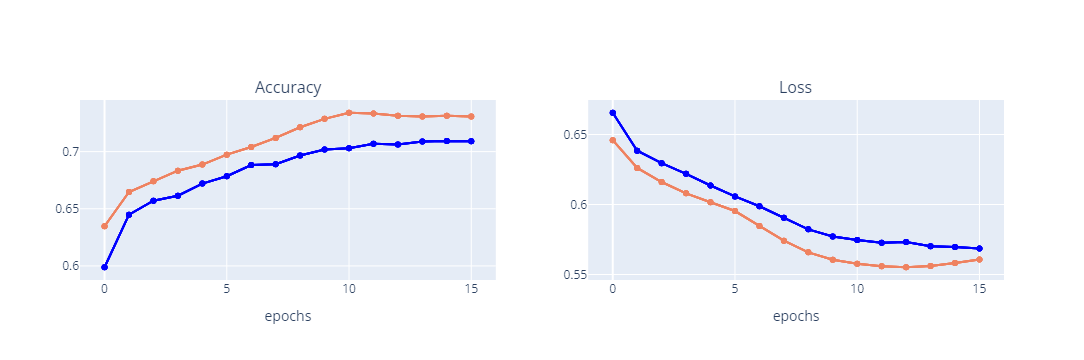

1 Dropout rate test start...
Repeat 0 running...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 150, 150)       │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 150, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.63072, saving model to ./saved_models/last_saved_model.keras
133/133 - 5s - 40ms/step - accuracy: 0.6204 - loss: 0.6649 - val_accuracy: 0.6533 - val_loss: 0.6307
Epoch 2/100

Epoch 2: val_loss improved from 0.63072 to 0.60849, saving model to ./saved_models/last_saved_model.keras
133/133 - 4s - 32ms/step - accuracy: 0.6535 - loss: 0.6317 - val_accuracy: 0.6807 - val_loss: 0.6085
Epoch 3/100

Epoch 3: val_loss improved from 0.60849 to 0.59028, saving model to ./saved_models/last_saved_model.keras
133/133 - 4s - 31ms/step - accuracy: 0.6719 - loss: 0.6165 - val_accuracy: 0.7000 - val_loss: 0.5903
Epoch 4/100

Epoch 4: val_loss improved from 0.59028 to 0.57069, saving model to ./saved_models/last_saved_model.keras
133/133 - 4s - 31ms/step - accuracy: 0.6833 - loss: 0.6013 - val_accuracy: 0.7167 - val_loss: 0.5707
Epoch 5/100

Epoch 5: val_loss improved from 0.57069 to 0.56012, saving model to ./saved_models/last_saved_model.keras
133/1

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 150, 150)       │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 150, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.63072, saving model to ./saved_models/last_saved_model.keras
133/133 - 6s - 44ms/step - accuracy: 0.6204 - loss: 0.6649 - val_accuracy: 0.6533 - val_loss: 0.6307
Epoch 2/100

Epoch 2: val_loss improved from 0.63072 to 0.60849, saving model to ./saved_models/last_saved_model.keras
133/133 - 4s - 31ms/step - accuracy: 0.6535 - loss: 0.6317 - val_accuracy: 0.6807 - val_loss: 0.6085
Epoch 3/100

Epoch 3: val_loss improved from 0.60849 to 0.59028, saving model to ./saved_models/last_saved_model.keras
133/133 - 4s - 31ms/step - accuracy: 0.6719 - loss: 0.6165 - val_accuracy: 0.7000 - val_loss: 0.5903
Epoch 4/100

Epoch 4: val_loss improved from 0.59028 to 0.57069, saving model to ./saved_models/last_saved_model.keras
133/133 - 4s - 32ms/step - accuracy: 0.6833 - loss: 0.6013 - val_accuracy: 0.7167 - val_loss: 0.5707
Epoch 5/100

Epoch 5: val_loss improved from 0.57069 to 0.56012, saving model to ./saved_models/last_saved_model.keras
133/1

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 150, 150)       │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 150, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.63072, saving model to ./saved_models/last_saved_model.keras
133/133 - 6s - 42ms/step - accuracy: 0.6204 - loss: 0.6649 - val_accuracy: 0.6533 - val_loss: 0.6307
Epoch 2/100

Epoch 2: val_loss improved from 0.63072 to 0.60849, saving model to ./saved_models/last_saved_model.keras
133/133 - 4s - 32ms/step - accuracy: 0.6535 - loss: 0.6317 - val_accuracy: 0.6807 - val_loss: 0.6085
Epoch 3/100

Epoch 3: val_loss improved from 0.60849 to 0.59028, saving model to ./saved_models/last_saved_model.keras
133/133 - 4s - 31ms/step - accuracy: 0.6719 - loss: 0.6165 - val_accuracy: 0.7000 - val_loss: 0.5903
Epoch 4/100

Epoch 4: val_loss improved from 0.59028 to 0.57069, saving model to ./saved_models/last_saved_model.keras
133/133 - 4s - 29ms/step - accuracy: 0.6833 - loss: 0.6013 - val_accuracy: 0.7167 - val_loss: 0.5707
Epoch 5/100

Epoch 5: val_loss improved from 0.57069 to 0.56012, saving model to ./saved_models/last_saved_model.keras
133/1

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 150, 150)       │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 150, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.63072, saving model to ./saved_models/last_saved_model.keras
133/133 - 6s - 43ms/step - accuracy: 0.6204 - loss: 0.6649 - val_accuracy: 0.6533 - val_loss: 0.6307
Epoch 2/100

Epoch 2: val_loss improved from 0.63072 to 0.60849, saving model to ./saved_models/last_saved_model.keras
133/133 - 4s - 32ms/step - accuracy: 0.6535 - loss: 0.6317 - val_accuracy: 0.6807 - val_loss: 0.6085
Epoch 3/100

Epoch 3: val_loss improved from 0.60849 to 0.59028, saving model to ./saved_models/last_saved_model.keras
133/133 - 4s - 31ms/step - accuracy: 0.6719 - loss: 0.6165 - val_accuracy: 0.7000 - val_loss: 0.5903
Epoch 4/100

Epoch 4: val_loss improved from 0.59028 to 0.57069, saving model to ./saved_models/last_saved_model.keras
133/133 - 4s - 32ms/step - accuracy: 0.6833 - loss: 0.6013 - val_accuracy: 0.7167 - val_loss: 0.5707
Epoch 5/100

Epoch 5: val_loss improved from 0.57069 to 0.56012, saving model to ./saved_models/last_saved_model.keras
133/1

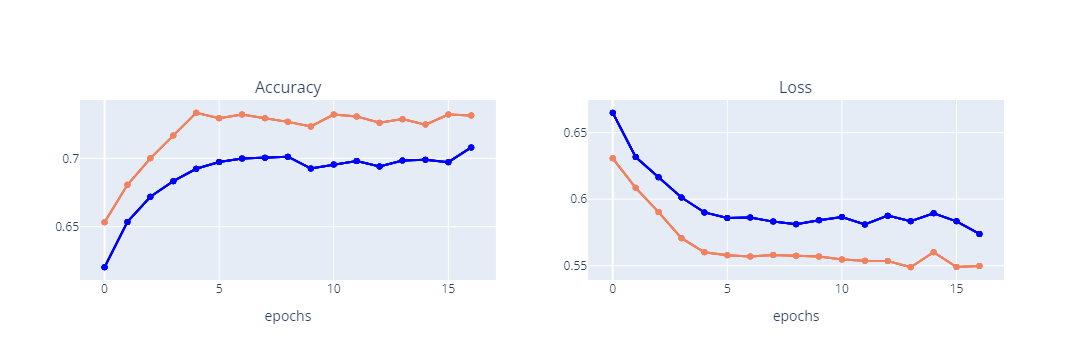

2 Dropout rate test start...
Repeat 0 running...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 150, 300)       │       366,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 150, 300)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 300)            │       721,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 150)            │        45,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,132,652 (4.32 MB)

 Trainable params: 1,132,652 (4.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.61882, saving model to ./saved_models/last_saved_model.keras
133/133 - 6s - 43ms/step - accuracy: 0.6358 - loss: 0.6522 - val_accuracy: 0.6700 - val_loss: 0.6188
Epoch 2/100

Epoch 2: val_loss improved from 0.61882 to 0.59249, saving model to ./saved_models/last_saved_model.keras
133/133 - 4s - 30ms/step - accuracy: 0.6641 - loss: 0.6223 - val_accuracy: 0.6967 - val_loss: 0.5925
Epoch 3/100

Epoch 3: val_loss improved from 0.59249 to 0.56667, saving model to ./saved_models/last_saved_model.keras
133/133 - 4s - 31ms/step - accuracy: 0.6820 - loss: 0.6030 - val_accuracy: 0.7240 - val_loss: 0.5667
Epoch 4/100

Epoch 4: val_loss improved from 0.56667 to 0.55869, saving model to ./saved_models/last_saved_model.keras
133/133 - 4s - 29ms/step - accuracy: 0.6911 - loss: 0.5910 - val_accuracy: 0.7307 - val_loss: 0.5587
Epoch 5/100

Epoch 5: val_loss improved from 0.55869 to 0.55629, saving model to ./saved_models/last_saved_model.keras
133/1

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 150, 300)       │       366,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 150, 300)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 300)            │       721,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 150)            │        45,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,132,652 (4.32 MB)

 Trainable params: 1,132,652 (4.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.61882, saving model to ./saved_models/last_saved_model.keras
133/133 - 6s - 44ms/step - accuracy: 0.6358 - loss: 0.6522 - val_accuracy: 0.6700 - val_loss: 0.6188
Epoch 2/100

Epoch 2: val_loss improved from 0.61882 to 0.59249, saving model to ./saved_models/last_saved_model.keras
133/133 - 4s - 31ms/step - accuracy: 0.6641 - loss: 0.6223 - val_accuracy: 0.6967 - val_loss: 0.5925
Epoch 3/100

Epoch 3: val_loss improved from 0.59249 to 0.56667, saving model to ./saved_models/last_saved_model.keras
133/133 - 4s - 32ms/step - accuracy: 0.6820 - loss: 0.6030 - val_accuracy: 0.7240 - val_loss: 0.5667
Epoch 4/100

Epoch 4: val_loss improved from 0.56667 to 0.55869, saving model to ./saved_models/last_saved_model.keras
133/133 - 4s - 32ms/step - accuracy: 0.6911 - loss: 0.5910 - val_accuracy: 0.7307 - val_loss: 0.5587
Epoch 5/100

Epoch 5: val_loss improved from 0.55869 to 0.55629, saving model to ./saved_models/last_saved_model.keras
133/1

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 150, 300)       │       366,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 150, 300)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 300)            │       721,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 150)            │        45,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,132,652 (4.32 MB)

 Trainable params: 1,132,652 (4.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.61882, saving model to ./saved_models/last_saved_model.keras
133/133 - 6s - 45ms/step - accuracy: 0.6358 - loss: 0.6522 - val_accuracy: 0.6700 - val_loss: 0.6188
Epoch 2/100

Epoch 2: val_loss improved from 0.61882 to 0.59249, saving model to ./saved_models/last_saved_model.keras
133/133 - 4s - 31ms/step - accuracy: 0.6641 - loss: 0.6223 - val_accuracy: 0.6967 - val_loss: 0.5925
Epoch 3/100

Epoch 3: val_loss improved from 0.59249 to 0.56667, saving model to ./saved_models/last_saved_model.keras
133/133 - 4s - 30ms/step - accuracy: 0.6820 - loss: 0.6030 - val_accuracy: 0.7240 - val_loss: 0.5667
Epoch 4/100

Epoch 4: val_loss improved from 0.56667 to 0.55869, saving model to ./saved_models/last_saved_model.keras
133/133 - 4s - 30ms/step - accuracy: 0.6911 - loss: 0.5910 - val_accuracy: 0.7307 - val_loss: 0.5587
Epoch 5/100

Epoch 5: val_loss improved from 0.55869 to 0.55629, saving model to ./saved_models/last_saved_model.keras
133/1

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 150, 300)       │       366,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 150, 300)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 300)            │       721,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 150)            │        45,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,132,652 (4.32 MB)

 Trainable params: 1,132,652 (4.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.61882, saving model to ./saved_models/last_saved_model.keras
133/133 - 6s - 43ms/step - accuracy: 0.6358 - loss: 0.6522 - val_accuracy: 0.6700 - val_loss: 0.6188
Epoch 2/100

Epoch 2: val_loss improved from 0.61882 to 0.59249, saving model to ./saved_models/last_saved_model.keras
133/133 - 4s - 31ms/step - accuracy: 0.6641 - loss: 0.6223 - val_accuracy: 0.6967 - val_loss: 0.5925
Epoch 3/100

Epoch 3: val_loss improved from 0.59249 to 0.56667, saving model to ./saved_models/last_saved_model.keras
133/133 - 4s - 32ms/step - accuracy: 0.6820 - loss: 0.6030 - val_accuracy: 0.7240 - val_loss: 0.5667
Epoch 4/100

Epoch 4: val_loss improved from 0.56667 to 0.55869, saving model to ./saved_models/last_saved_model.keras
133/133 - 4s - 32ms/step - accuracy: 0.6911 - loss: 0.5910 - val_accuracy: 0.7307 - val_loss: 0.5587
Epoch 5/100

Epoch 5: val_loss improved from 0.55869 to 0.55629, saving model to ./saved_models/last_saved_model.keras
133/1

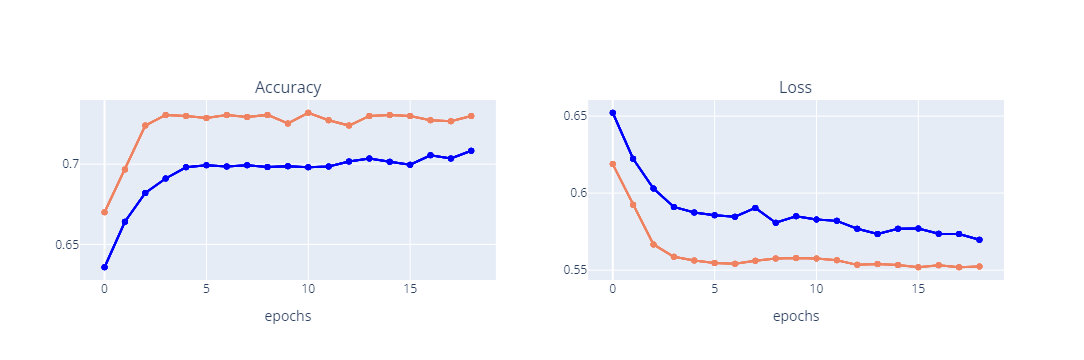

               0          1          2
count   4.000000   4.000000   4.000000
mean   73.133332  72.866666  73.000002
std     0.000000   0.000000   0.000000
min    73.133332  72.866666  73.000002
25%    73.133332  72.866666  73.000002
50%    73.133332  72.866666  73.000002
75%    73.133332  72.866666  73.000002
max    73.133332  72.866666  73.000002
          0     1     2
count  4.00  4.00  4.00
mean  -5.53 -6.13 -7.44
std    0.00  0.00  0.00
min   -5.53 -6.13 -7.44
25%   -5.53 -6.13 -7.44
50%   -5.53 -6.13 -7.44
75%   -5.53 -6.13 -7.44
max   -5.53 -6.13 -7.44


In [8]:
# Run
from numpy import dtype

repeats = 4
runMeter = 0
results_acc = DataFrame(dtype='float')
results_profit = DataFrame(dtype='float')
metrics = list()

# vary training epochs
learning_rate = 0.001
features = 0
model = [0, 1, 2]
dropout = 0 # [0.2, 0.4, 0.6, 0.8]
denseType = 0
neuronsLstm = 150
timeStep = 150
epochs = 100

# Data gen
x_train, x_test, y_train, y_test, Y_test = data(timeStep, features)

# for dr in dropout:
for mod in model:
 print(f"{mod} Dropout rate test start...")
 
 results_acc[str(mod)], results_profit[str(mod)], metrics = experiment(runMeter, repeats, epochs, neuronsLstm, timeStep, denseType, dropout, mod, features, learning_rate)
 # runMeter += 1
 plotsOut(mod, metrics)

# summarize results
print(results_acc.describe())
print(results_profit.describe())

In [9]:
# summarize results
print(results_acc.describe())
print(results_profit.describe())

               0          1          2
count   4.000000   4.000000   4.000000
mean   73.133332  72.866666  73.000002
std     0.000000   0.000000   0.000000
min    73.133332  72.866666  73.000002
25%    73.133332  72.866666  73.000002
50%    73.133332  72.866666  73.000002
75%    73.133332  72.866666  73.000002
max    73.133332  72.866666  73.000002
          0     1     2
count  4.00  4.00  4.00
mean  -5.53 -6.13 -7.44
std    0.00  0.00  0.00
min   -5.53 -6.13 -7.44
25%   -5.53 -6.13 -7.44
50%   -5.53 -6.13 -7.44
75%   -5.53 -6.13 -7.44
max   -5.53 -6.13 -7.44


               0          1          2
count   4.000000   4.000000   4.000000
mean   73.133332  72.866666  73.000002
std     0.000000   0.000000   0.000000
min    73.133332  72.866666  73.000002
25%    73.133332  72.866666  73.000002
50%    73.133332  72.866666  73.000002
75%    73.133332  72.866666  73.000002
max    73.133332  72.866666  73.000002


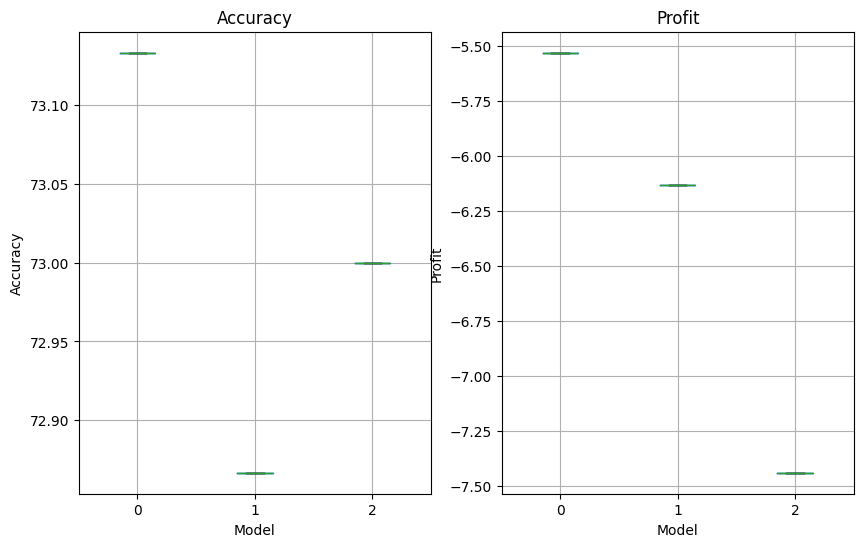

In [10]:
%matplotlib inline
print(results_acc.describe())

# 2 subplots in one row
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

# Generate boxplots
results_acc.boxplot(ax=ax[0])
results_profit.boxplot(ax=ax[1])

# Set labels and titles
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Model')
ax[0].set_ylabel('Accuracy')
ax[1].set_title('Profit')
ax[1].set_xlabel('Model')
ax[1].set_ylabel('Profit')

# Save to .png and show plot
plt.savefig(f'boxplot_model.png')
plt.show()